In [1]:
import sys 
!{sys.executable} -m pip install --user yacs

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
import cv2
import math
from utils_inference import get_lmks_by_img, get_model_by_name, get_preds, decode_preds, crop, detect_direction
from utils_landmarks import show_landmarks, get_five_landmarks_from_net, alignment_orig

In [3]:
import os
from os.path import join as ospj

path = "./images/SHW"
file_list = os.listdir(path)
img_paths = [file for file in file_list if file.endswith(".JPG")]
print(img_paths)

['DSC_3575.JPG', 'DSC_3581.JPG', 'DSC_3567.JPG', 'DSC_3550.JPG', 'DSC_3574.JPG', 'DSC_3568.JPG', 'DSC_3551.JPG', 'DSC_3561.JPG', 'DSC_3571.JPG', 'DSC_3560.JPG', 'DSC_3570.JPG', 'DSC_3549.JPG', 'DSC_3555.JPG', 'DSC_3566.JPG', 'DSC_3552.JPG', 'DSC_3576.JPG', 'DSC_3554.JPG', 'DSC_3584.JPG', 'DSC_3580.JPG', 'DSC_3564.JPG', 'DSC_3569.JPG', 'DSC_3586.JPG', 'DSC_3572.JPG', 'DSC_3557.JPG', 'DSC_3578.JPG', 'DSC_3589.JPG', 'DSC_3548.JPG', 'DSC_3590.JPG', 'DSC_3556.JPG', 'DSC_3577.JPG', 'DSC_3563.JPG', 'DSC_3582.JPG', 'DSC_3565.JPG', 'DSC_3579.JPG', 'DSC_3573.JPG', 'DSC_3547.JPG', 'DSC_3588.JPG', 'DSC_3558.JPG', 'DSC_3553.JPG', 'DSC_3583.JPG']


In [4]:
def Area(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

def calc_area(img):
    lmks = img['lmks']
    left_eye  = lmks[0]
    right_eye = lmks[1]
    nose      = lmks[2]
    left_lip  = lmks[3]
    right_lip = lmks[4]
    
    return Area([nose, left_eye, right_eye]), Area([nose, left_lip, right_lip])

In [2]:
def get_lmks_with_dicts(model, img_paths):
    i = 0
    for img_path in img_paths:
        i +=1
        print(i)
        img_dict = {}
        img = cv2.imread(ospj(path,img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_dict['img'] = img
        img_dict['width'] = img.shape[1]
        img_dict['height'] = img.shape[0]

        lmks = get_lmks_by_img(model, img) 
        five_lmks = get_five_landmarks_from_net(lmks)
        img_dict['lmks'] = five_lmks
        img_dict['top_area'], img_dict['bottom_area'] = calc_area(img_dict)


        left_eye  = five_lmks[0]
        right_eye = five_lmks[1]
        nose      = five_lmks[2]
        left_lip  = five_lmks[3]
        right_lip = five_lmks[4]

        img_dict["direction"] = detect_direction(five_lmks, img.shape[1])
        img_dict["eye2eye"] = abs(left_eye[0] - right_eye[0])
        img_dict["eye2lip"] = abs((left_eye[1]+right_eye[1])/2 - (left_lip[1]+right_lip[1])/2)
        img_dict["lip2lip"] = abs(left_lip[0] - right_lip[0])
        imgs_dict[img_path] = img_dict
    return imgs_dict

In [3]:
def sort_imgs_to_set(img_dicts):
    # landscape
    # ready to split btw zoom_in & zoom_out
    distance_btw_lips = []
    distance_btw_eye2lip = []
    for k in imgs_dict.keys():
        width = imgs_dict[k]['width']
        height = imgs_dict[k]['height']
        lmks = imgs_dict[k]['lmks']

        if width > height:
            landscape_d[k] = imgs_dict[k]
        else:
            left_eye = lmks[0]
            right_eye = lmks[1]
            left_lip = lmks[3]
            right_lip = lmks[4]
            distance_btw_lips.append(imgs_dict[k]["lip2lip"])
            distance_btw_eye2lip.append(imgs_dict[k]["eye2lip"])
   
    import matplotlib.pyplot as plt
    bound_w = plt.hist(distance_btw_lips, bins=2)
    bound_h = plt.hist(distance_btw_eye2lip, bins=2)
    half_w = bound_w[1][1]
    half_h = bound_h[1][1]
    
    #zoom_in / zoom_out
    for k in imgs_dict.keys():
        width = imgs_dict[k]['width']
        height = imgs_dict[k]['height']
        lmks = imgs_dict[k]['lmks']

        left_eye  = lmks[0]
        right_eye = lmks[1]
        left_lip  = lmks[3]
        right_lip = lmks[4]

        if width < height:
            btw_lips = abs(left_lip[0] - right_lip[0])
            btw_eye2lip = abs((left_lip[1]+right_lip[1])/2 - (left_eye[1]+right_eye[1])/2)
            if btw_lips > half_w or btw_eye2lip > half_h:
                zoom_in_d[k] = imgs_dict[k]
            else:
                zoom_out_d[k] = imgs_dict[k]
    return landscape_d, zoom_in_d, zoom_out_d

In [4]:
def sort_set_to_dirtype(target_d):
    target_d = landscape_d
    print(target_d.keys())
    h_d = {}
    v_d = {}
    o_d = {}
    _temp_l = []
    for k in target_d.keys():
        target = target_d[k]
        direction = target["direction"]
        if direction != 2:
            h_d[k] = target_d[k]
        else:  
            lmks = target_d[k]['lmks']
            left_eye  = lmks[0]
            right_eye = lmks[1]
            nose      = lmks[2]
            left_lip  = lmks[3]
            right_lip = lmks[4]

            _temp_l.append(abs(1-abs((left_eye[1]+right_eye[1])/2 - nose[1])/abs((left_lip[1]+right_lip[1])/2 -nose[1])))

    boundary = plt.hist(_temp_l, bins=2)[1][1]

    for k in target_d.keys():
        target = target_d[k]
        direction = target["direction"]
        if direction == 2:
            lmks = target_d[k]['lmks']
            left_eye  = lmks[0]
            right_eye = lmks[1]
            nose      = lmks[2]
            left_lip  = lmks[3]
            right_lip = lmks[4]
            updown_ratio = abs(1-abs((left_eye[1]+right_eye[1])/2 - nose[1])/abs((left_lip[1]+right_lip[1])/2 - nose[1]))
            if updown_ratio < boundary :
                o_d[k] = target_d[k]
            else:
                v_d[k] = target_d[k]
   
    target_split_d = {}          
    target_split_d["origin"] = o_d
    target_split_d["horizontal"] = h_d
    target_split_d["vertical"] = v_d
    return target_split_d


In [5]:
def sort_all_sets_to_dirtype(landscape_d, zoom_in_d, zoom_out_d):
    landscape = sort_set_to_dirtype(landscape_d)
    zoom_in   = sort_set_to_dirtype(zoom_in_d)
    zoom_out  = sort_set_to_dirtype(zoom_out_d)
    return landscape, zoom_in, zoom_out

In [13]:
#landscape_split_d/ zoom_in_split_d/ zoom_out_split_d

In [24]:
def align_center(target, shift_w, shift_h):
    import numpy as np
    T = [ [1, 0, shift_w],
         [0, 1, shift_h] 
        ]
    T = np.float32(T)
    transformed_img = cv2.warpAffine(target["img"], T, (target['width'],target['height']))
    cropped_img = transformed_img[int(max(0, shift_h)):int(min(target['height'], target['height']+shift_h)),
                                int(max(0, shift_w)):int(min(target['width'], target['width']+shift_w))]
    return cropped_img

In [25]:
def set_ref_imgsize(target_d):
    max_shift_w = 0
    max_shift_h = 0
    for k in target_d["origin"].keys():
        shift_w = nose[0]-target['width']/2
        shift_h = -1*(nose[1]-target['height']/2)
        if abs(max_shift_w) < abs(shift_w):
            max_shift_w = shift_w
            ref_img = k
        if abs(max_shift_h) < abs(shift_h):
            max_shift_h = shift_h
            ref_img = k
    target_d["shift_w"] = max_shift_w
    target_d["shift_h"] = max_shift_h
    target_d["ref_ori"] = ref_img
    return target_d["shift_w"], target_d["shift_h"]
  

In [26]:
def align_with_origin_horizontal(target_d):
    ref_name = target_d["ref_ori"]
    ref_lmks = target_d["origin"][ref_name]["lmks"]
    ref_eye  = (ref_lmks[0] + ref_lmks[1])/2
    ref_nose = ref_lmks[2]
    ref_lip  = (ref_lmks[3] + ref_lmks[4])/2
    shitf_w, shift_h = target_d["shift_w"], target_d["shift_h"]
    for k in target_d["horizontal"].keys():
        target = target_d["horizontal"][k]
        lmks = target_d["horizontal"][k]["lmks"]
        eye = (lmks[0] + lmks[1])/2
        nose = lmks[2]
        lip = (lmks[3] + lmks[4])/2
        
        _shift_h = (ref_eye[1] - eye[1]) + shift_h
        print(_shift_h)
        import numpy as np
        T = [ [1, 0, 0],
             [0, 1, _shift_h] 
            ]
        T = np.float32(T)
        transformed_img = cv2.warpAffine(target["img"], T, (target['width'],target['height']))
        cropped_img = transformed_img[int(max(0, _shift_h)):int(min(target['height'], target['height']+_shift_h)),
                                    :]
        target_d["horizontal"][k]["crop_img"] = cropped_img

In [27]:
def align_origin(target_d):
    target_dict = target_d["origin"]
    for k in target_dict.keys():
        target = target_dict[k]
        target["crop_img"] = align_center(target, target_d["shift_w"], target_d["shift_h"])

DSC_3581.JPG


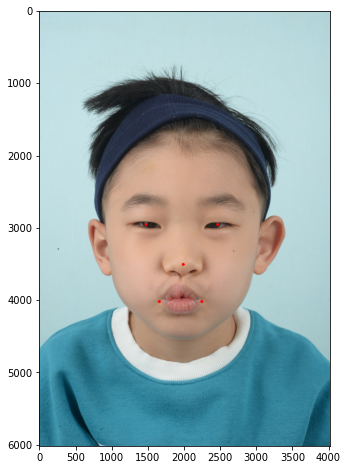

1098.5
eyes align height: 0.000000
eyes align width: -991.000000
lips align height: 0.000000
lips align width: -587.000000
vertical nose2eye: -18.500000
vertical lip2eye: 18.000000
vertical nose2lip: -36.500000
DSC_3580.JPG


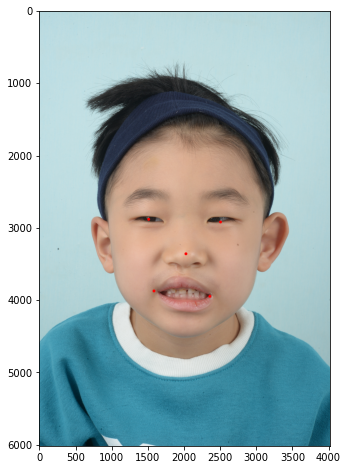

3508.0625
eyes align height: -37.000000
eyes align width: -991.000000
lips align height: -74.000000
lips align width: -771.000000
vertical nose2eye: -18.500000
vertical lip2eye: 37.000000
vertical nose2lip: -55.500000
DSC_3548.JPG


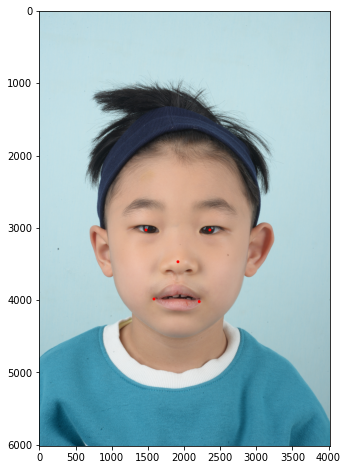

2257.3125
eyes align height: 0.000000
eyes align width: -881.000000
lips align height: -36.000000
lips align width: -624.000000
vertical nose2eye: -0.500000
vertical lip2eye: 18.500000
vertical nose2lip: -19.000000
DSC_3582.JPG


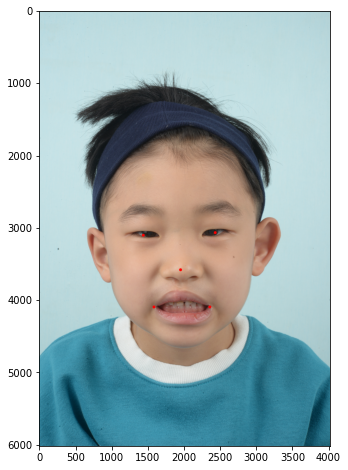

81.0625
eyes align height: 36.000000
eyes align width: -992.000000
lips align height: 0.000000
lips align width: -771.000000
vertical nose2eye: -18.000000
vertical lip2eye: -36.500000
vertical nose2lip: 18.500000
DSC_3579.JPG


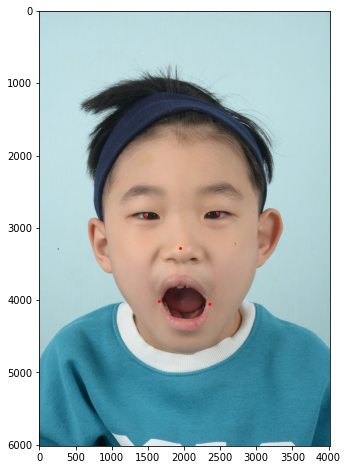

22904.5625
eyes align height: 36.000000
eyes align width: -991.000000
lips align height: -37.000000
lips align width: -697.000000
vertical nose2eye: 18.500000
vertical lip2eye: -37.000000
vertical nose2lip: 55.500000
DSC_3547.JPG


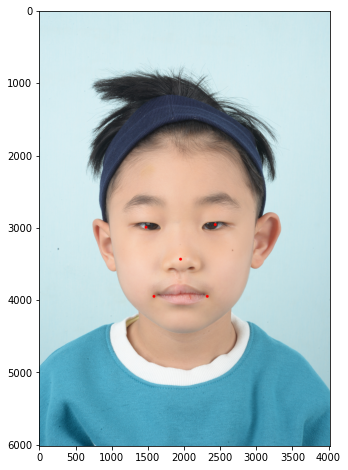

742.8125
eyes align height: 37.000000
eyes align width: -955.000000
lips align height: 0.000000
lips align width: -735.000000
vertical nose2eye: 0.500000
vertical lip2eye: 0.000000
vertical nose2lip: 0.500000


In [28]:
target_d = zoom_out_split_d
target_dict = target_d["origin"]
for k in target_dict.keys():
    print(k)
    CIRCLE_SIZE = target_dict[k]['width']//200
    show_landmarks(target_dict[k]['img'], target_dict[k]['lmks'], circle_size=CIRCLE_SIZE)
    lmks = target_dict[k]['lmks']
    left_eye  = lmks[0]
    right_eye = lmks[1]
    nose      = lmks[2]
    left_lip  = lmks[3]
    right_lip = lmks[4]
    
    middle_eye = (left_eye + right_eye)/2
    middle_lip = (left_lip + right_lip)/2
    
    diff = (left_eye + right_eye + left_lip + right_lip)/4 - nose
    dist = diff[0]**2 + diff[1]**2
    print(dist)
    
    print("eyes align height: %f" % (left_eye[1] - right_eye[1]))
    print("eyes align width: %f" % (left_eye[0] - right_eye[0]))
    print("lips align height: %f" % (left_lip[1] - right_lip[1]))
    print("lips align width: %f" % (left_lip[0] - right_lip[0]))
    print("vertical nose2eye: %f" % (middle_eye[0] - nose[0]))
    print("vertical lip2eye: %f" % (middle_eye[0] - middle_lip[0]))
    print("vertical nose2lip: %f" % (middle_lip[0] - nose[0]))

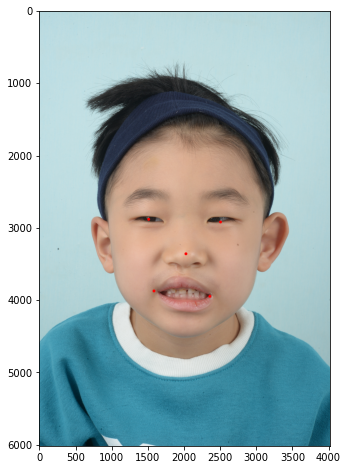

3508.0625
eyes align height: -37.000000
eyes align width: -991.000000
lips align height: -74.000000
lips align width: -771.000000
vertical nose2eye: -18.500000
vertical lip2eye: 37.000000
vertical nose2lip: -55.500000


In [29]:
target_name = "DSC_3580.JPG"
target_d = zoom_out_split_d
target = target_d["origin"][target_name]

CIRCLE_SIZE = target['width']//200
show_landmarks(target['img'], target['lmks'], circle_size=CIRCLE_SIZE)

lmks = target['lmks']
left_eye  = lmks[0]
right_eye = lmks[1]
nose      = lmks[2]
left_lip  = lmks[3]
right_lip = lmks[4]

middle_eye = (left_eye + right_eye)/2
middle_lip = (left_lip + right_lip)/2

diff = (left_eye + right_eye + left_lip + right_lip)/4 - nose
dist = diff[0]**2 + diff[1]**2
print(dist)

print("eyes align height: %f" % (left_eye[1] - right_eye[1]))
print("eyes align width: %f" % (left_eye[0] - right_eye[0]))
print("lips align height: %f" % (left_lip[1] - right_lip[1]))
print("lips align width: %f" % (left_lip[0] - right_lip[0]))
print("vertical nose2eye: %f" % (middle_eye[0] - nose[0]))
print("vertical lip2eye: %f" % (middle_eye[0] - middle_lip[0]))
print("vertical nose2lip: %f" % (middle_lip[0] - nose[0]))

[2027. 3357.]
2008.0
3008.0


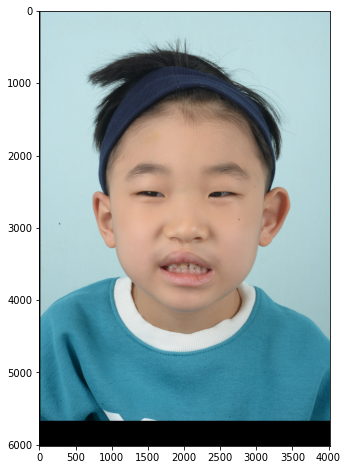

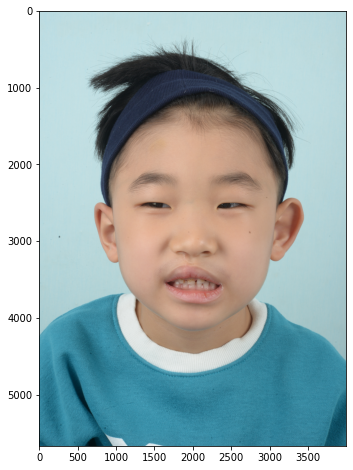

In [30]:
#R = cv2.getRotationMatrix2D((/2, h/2), 90, 1)
import numpy as np
shift_w = nose[0]-target['width']/2
shift_h = -1*(nose[1]-target['height']/2)
T = [ [1, 0, shift_w],
     [0, 1, shift_h] 
    ]
T = np.float32(T)

print(nose)
print(target['width']/2)
print(target['height']/2)
transformed_img = cv2.warpAffine(target["img"], T, (target['width'],target['height']))
cropped_img = transformed_img[int(max(0, shift_h)):int(min(target['height'], target['height']+shift_h)),
                            int(max(0, shift_w)):int(min(target['width'], target['width']+shift_w))]
plt.figure(figsize=(10,8))
plt.imshow(transformed_img)
plt.show()

plt.figure(figsize=(10,8))
plt.imshow(cropped_img)
plt.show()

19.0


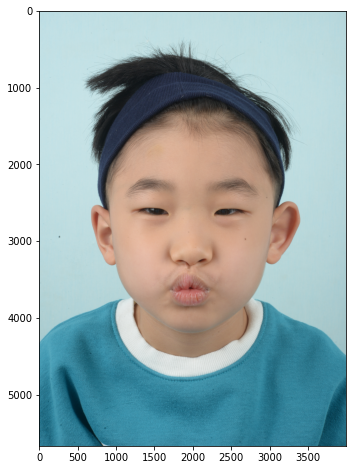

19.0


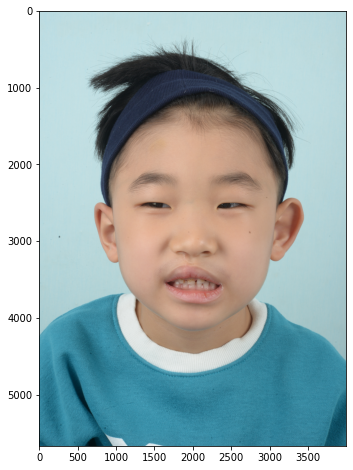

19.0


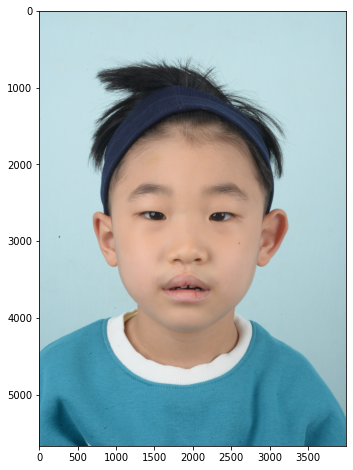

19.0


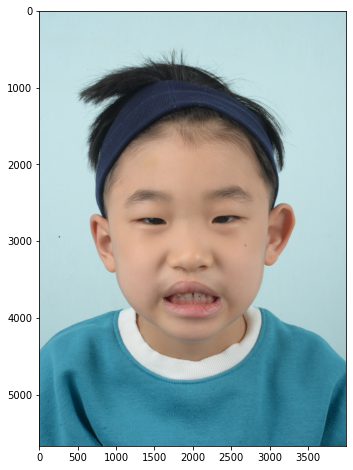

19.0


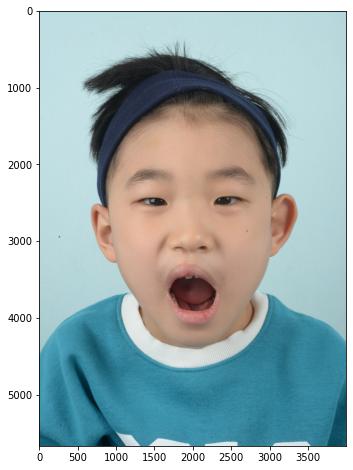

19.0


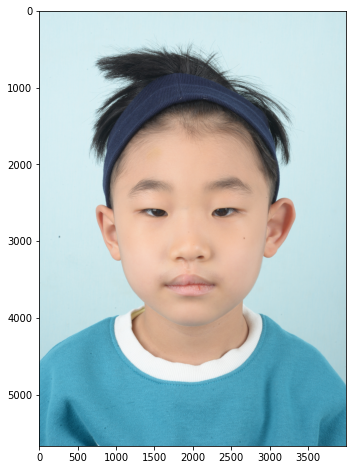

In [31]:
target_d = zoom_out_split_d
target_dict = target_d["origin"]
shift_w, shift_h = set_ref_imgsize(target_d)
for k in target_dict.keys():
    print(shift_w)
    target = target_dict[k]
    plt.figure(figsize=(10,8))
    plt.imshow(align_center(target, shift_w, shift_h))
    plt.show()

In [32]:
target_d = zoom_in_split_d
target_dict = target_d["origin"]
shift_w, shift_h = set_ref_imgsize(target_d)
align_origin(target_d)

In [33]:
# landscape는 nose to center 정렬 안함
# zoom_in/zoom_out 은 origin으로 nose_to_center

-276.0
-331.0
-460.0
-478.0


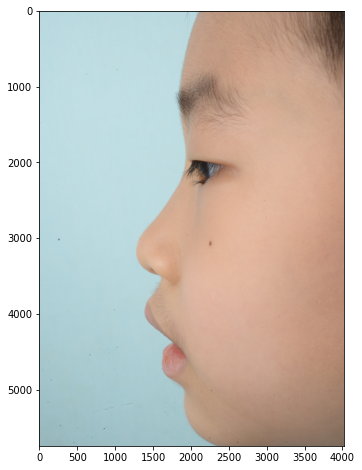

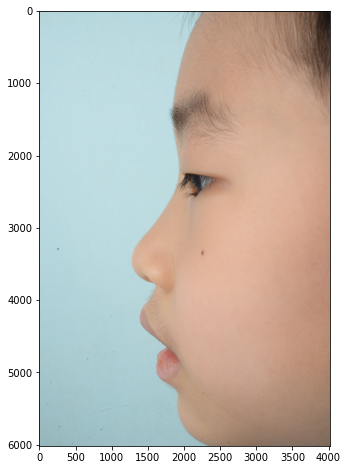

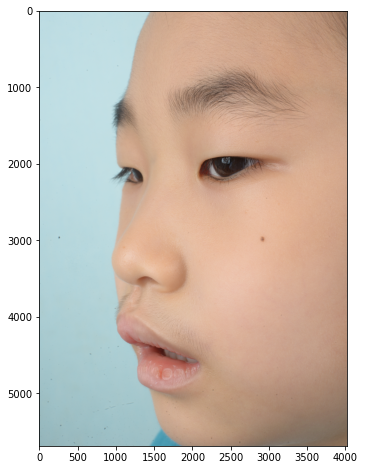

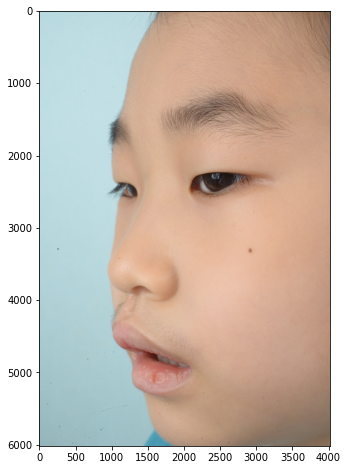

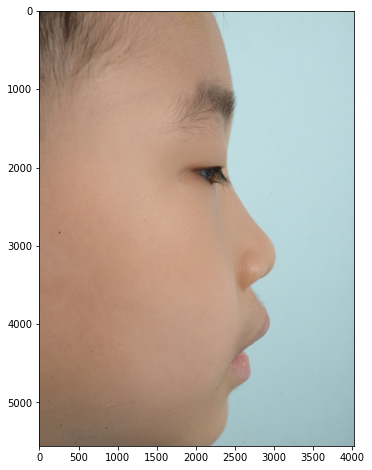

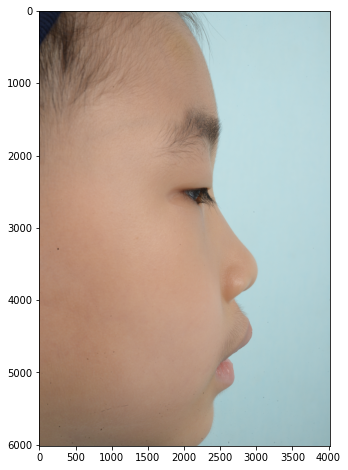

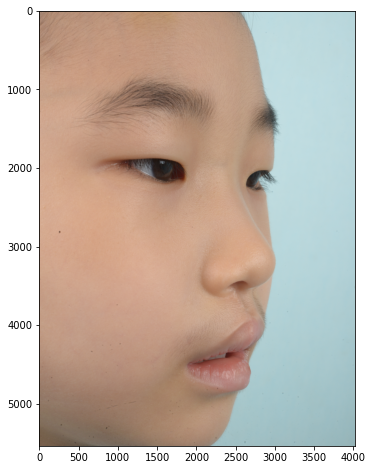

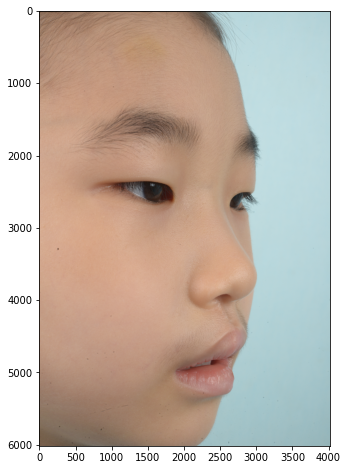

In [34]:
target_d = zoom_in_split_d
align_with_origin_horizontal(target_d)
target_dict = target_d["horizontal"]

crop_img_l = []
img_l = []
for k in target_dict.keys():
    target = target_dict[k]
    plt.figure(figsize=(10,8))
    plt.imshow(target["crop_img"])
    plt.show()
    crop_img_l.append(target["crop_img"])
    
    plt.figure(figsize=(10,8))
    plt.imshow(target["img"])
    plt.show()
    img_l.append(target["img"])

        
        

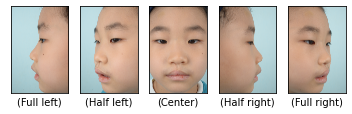

In [35]:
fig = plt.figure() # rows*cols 행렬의 i번째 subplot 생성
rows = 1
cols = 5
 
xlabels = ["label",  "(Full left)", "(Half left)", "(Center)", "(Half right)", "(Full right)"]

i=1
for ix in range(cols):
    ax = fig.add_subplot(rows, cols, ix+1)
    if ix != 2:
        ax.imshow(img_l[i-1])
        i += 1

    else:
        ref_img = zoom_in_split_d["ref_ori"]
        ax.imshow(zoom_in_split_d["origin"][ref_img]["img"])
    ax.set_xlabel(xlabels[ix+1])
    ax.set_xticks([]), ax.set_yticks([])
plt.show()



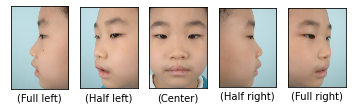

In [36]:
fig = plt.figure() # rows*cols 행렬의 i번째 subplot 생성
rows = 1
cols = 5


i = 1
for ix in range(cols):
    ax = fig.add_subplot(rows, cols, ix+1)
    if ix != 2:
        ax.imshow(crop_img_l[i-1])
        i += 1

    else:
        ref_img = zoom_in_split_d["ref_ori"]
        ax.imshow(zoom_in_split_d["origin"][ref_img]["crop_img"])

    ax.set_xlabel(xlabels[ix+1])
    ax.set_xticks([]), ax.set_yticks([])

plt.show()

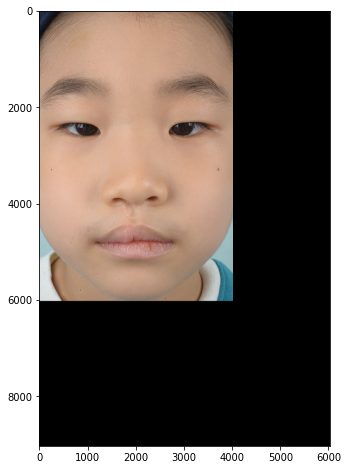

In [45]:
ref_name = zoom_in_split_d["ref_ori"]
target = zoom_in_split_d["origin"][ref_name]
import numpy as np
T = [ [1, 0, 0],
     [0, 1, 0] 
    ]
T = np.float32(T)
transformed_img = cv2.warpAffine(target["img"], T, (target['width']*3//2,target['height']*3//2))

plt.figure(figsize=(10,8))
plt.imshow(transformed_img)
plt.show()


In [ ]:
def shift_to_boardcenter(target_dict):
    board_w, board_h = None, None
    for k in target_dict.keys():
        target = target_dict[k]
        
        if board_w is None:
            board_w = target["width"]*3//2
            board_h = target["height"]*3//2
            
        shift_w = (board_w - target["width"])//2
        shift_h = (board_h - target["height"])//2
        
        T = [ [1, 0, shift_w],
             [0, 1, shift_h] 
            ]
        T = np.float32(T)
        transformed_img = cv2.warpAffine(target["img"], T, (board_w, board_h))
        target["crop_img"] = transformed_img
    return board_w, board_h

In [59]:
def shift_to_boardcenter_all(target_dicts):
    board_h, board_w = shift_to_boardcenter(target_dicts["origin"])
    board_h, board_w = shift_to_boardcenter(target_dicts["horizontal"])
    board_h, board_w = shift_to_boardcenter(target_dicts["vertical"])
    return board_h, board_w

In [76]:
def set_ref_img(target_dicts):
    max_shift_w = 0
    max_shift_h = 0
    for k in target_dicts["origin"].keys():
        target = target_dicts["origin"][k]
        lmks = target_dicts["origin"][k]["lmks"]
        eye = (lmks[0] + lmks[1])/2
        nose = lmks[2]
        lip = (lmks[3] + lmks[4])/2
        
        shift_w = target['width']/2 - nose[0]
        shift_h = target['height']/2 - nose[1]
        if abs(max_shift_w) < abs(shift_w):
            max_shift_w = shift_w
            ref_img = k
        if abs(max_shift_h) < abs(shift_h):
            max_shift_h = shift_h
            ref_img = k
    target_dicts["shift_w"] = max_shift_w
    target_dicts["shift_h"] = max_shift_h
    target_dicts["ref_ori"] = ref_img


In [77]:
def align_each(target_dicts, dir_type, align_where):
    board_w = target_dicts["board_w"]
    board_h = target_dicts["board_h"]
    for k in target_dicts[dir_type].keys():
        target = target_dicts[dir_type][k]
        lmks = target["lmks"]
        eye = (lmks[0] + lmks[1])/2
        nose = lmks[2]
        lip = (lmks[3] + lmks[4])/2
        
        if align_where == "eye":
            _align_where = eye
        elif align_where == "nose":
            _align_where = nose
        elif align_where == "lip":
             _align_where = lip
        else:
            raise ValueError

        if dir_type == "origin":
            shift_w = target['width']/2 - _align_where[0]
            shift_h = target['height']/2 - _align_where[1]
        elif dir_type == "horizontal":
            shift_w = 0
            shift_h = target['height']/2 - _align_where[1]   
        elif dir_type == "vertical":
            shift_w = target['width']/2 - _align_where[0]
            shift_h = 0 
        else:
            raise ValueError
            
        
        T = [ [1, 0, shift_w],
             [0, 1, shift_h] 
            ]
        T = np.float32(T)
        transformed_img = cv2.warpAffine(target["crop_img"], T, (board_w, board_h))
        target["crop_img"] = transformed_img
    

    

In [78]:
def align(target_dicts, align_where):
    align_each(target_dicts, "origin", align_where)
    align_each(target_dicts, "horizontal", align_where)
    align_each(target_dicts, "vertical", align_where)
    

In [ ]:
def crop_each(target_dicts, dir_type):
    ref_shift_w = target_dicts["shift_w"]
    ref_shift_h = target_dicts["shift_h"]

    board_w = target_dicts["board_w"]
    board_h = target_dicts["board_h"]
    
    for k in target_dicts[dir_type].keys():
        target = target_dicts[dir_type][k]
        width = target['width']
        height = target['height']
        
        offset_w = width//2 - abs(ref_shift_w)
        offset_h = height//2 - abs(ref_shift_h)
    
        target["crop_img"] = target["crop_img"][int(board_h//2 - offset_h):int(board_h//2 + offset_h),
                                                int(board_w//2 - offset_w):int(board_w//2 + offset_w)]


In [ ]:
def crop(target_dicts):
    crop_each(target_dicts, "origin")
    crop_each(target_dicts, "horizontal")
    crop_each(target_dicts, "vertical")

In [ ]:
def edit_all_images(target_dicts, align_where):
    
    #"crop_img" generate, attach to board
    board_w, board_h = shift_to_boardcenter_all(target_dicts)
    target_dicts["board_w"] = board_w
    target_dicts["board_h"] = board_h
    
    #"shift_w" ,"shift_h", "ref_ori" generate
    set_ref_img(target_dicts)
    
    # align : update @ "crop_img"
    align(target_dicts, align_where)
    crop(target_dicts)


In [ ]:
edit_all_images(zoom_in_split_d, "eye")
for k in zoom_in_split_d['horizontal'].keys():
    target = zoom_in_split_d['horizontal'][k]
    plt.figure(figsize=(10,8))
    plt.imshow(target["img"])
    plt.show()
    
    plt.figure(figsize=(10,8))
    plt.imshow(target["crop_img"])
    plt.show()

In [ ]:
print(zoom_in_split_d['board_h'])

In [ ]:
print(zoom_in_split_d['board_h'])